<a href="https://colab.research.google.com/github/RuslanDulaev/prediction_of_houses_price/blob/main/house_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

## Инициализация датафрейма

In [2]:
df = pd.read_csv("Housing.csv")

In [3]:
df.info()
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB
              price          area    bedrooms   bathrooms     stories  \
count  5.450000e+02    545.000000  545.000000  545.000000  545.000000   
mean   4

## Визуализация распределения цены


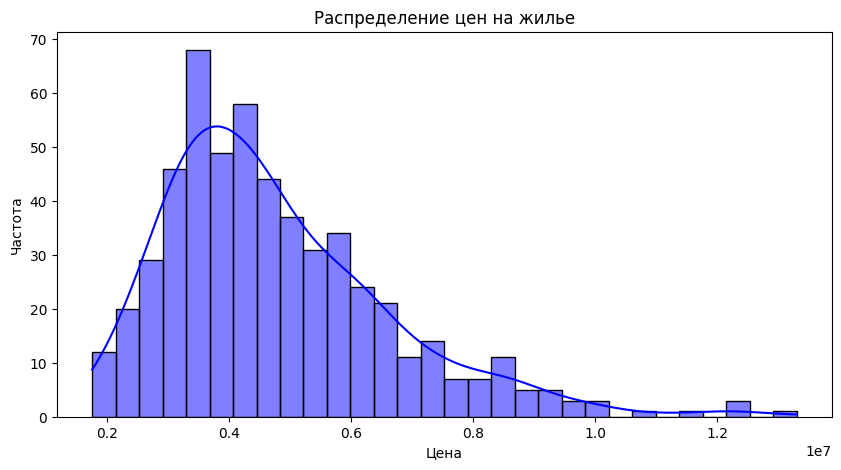

In [4]:
plt.figure(figsize=(10, 5))
sns.histplot(df['price'], kde=True, bins=30, color='blue')
plt.title("Распределение цен на жилье")
plt.xlabel("Цена")
plt.ylabel("Частота")
plt.show()

In [5]:
df

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished


## Построение графика pairplot

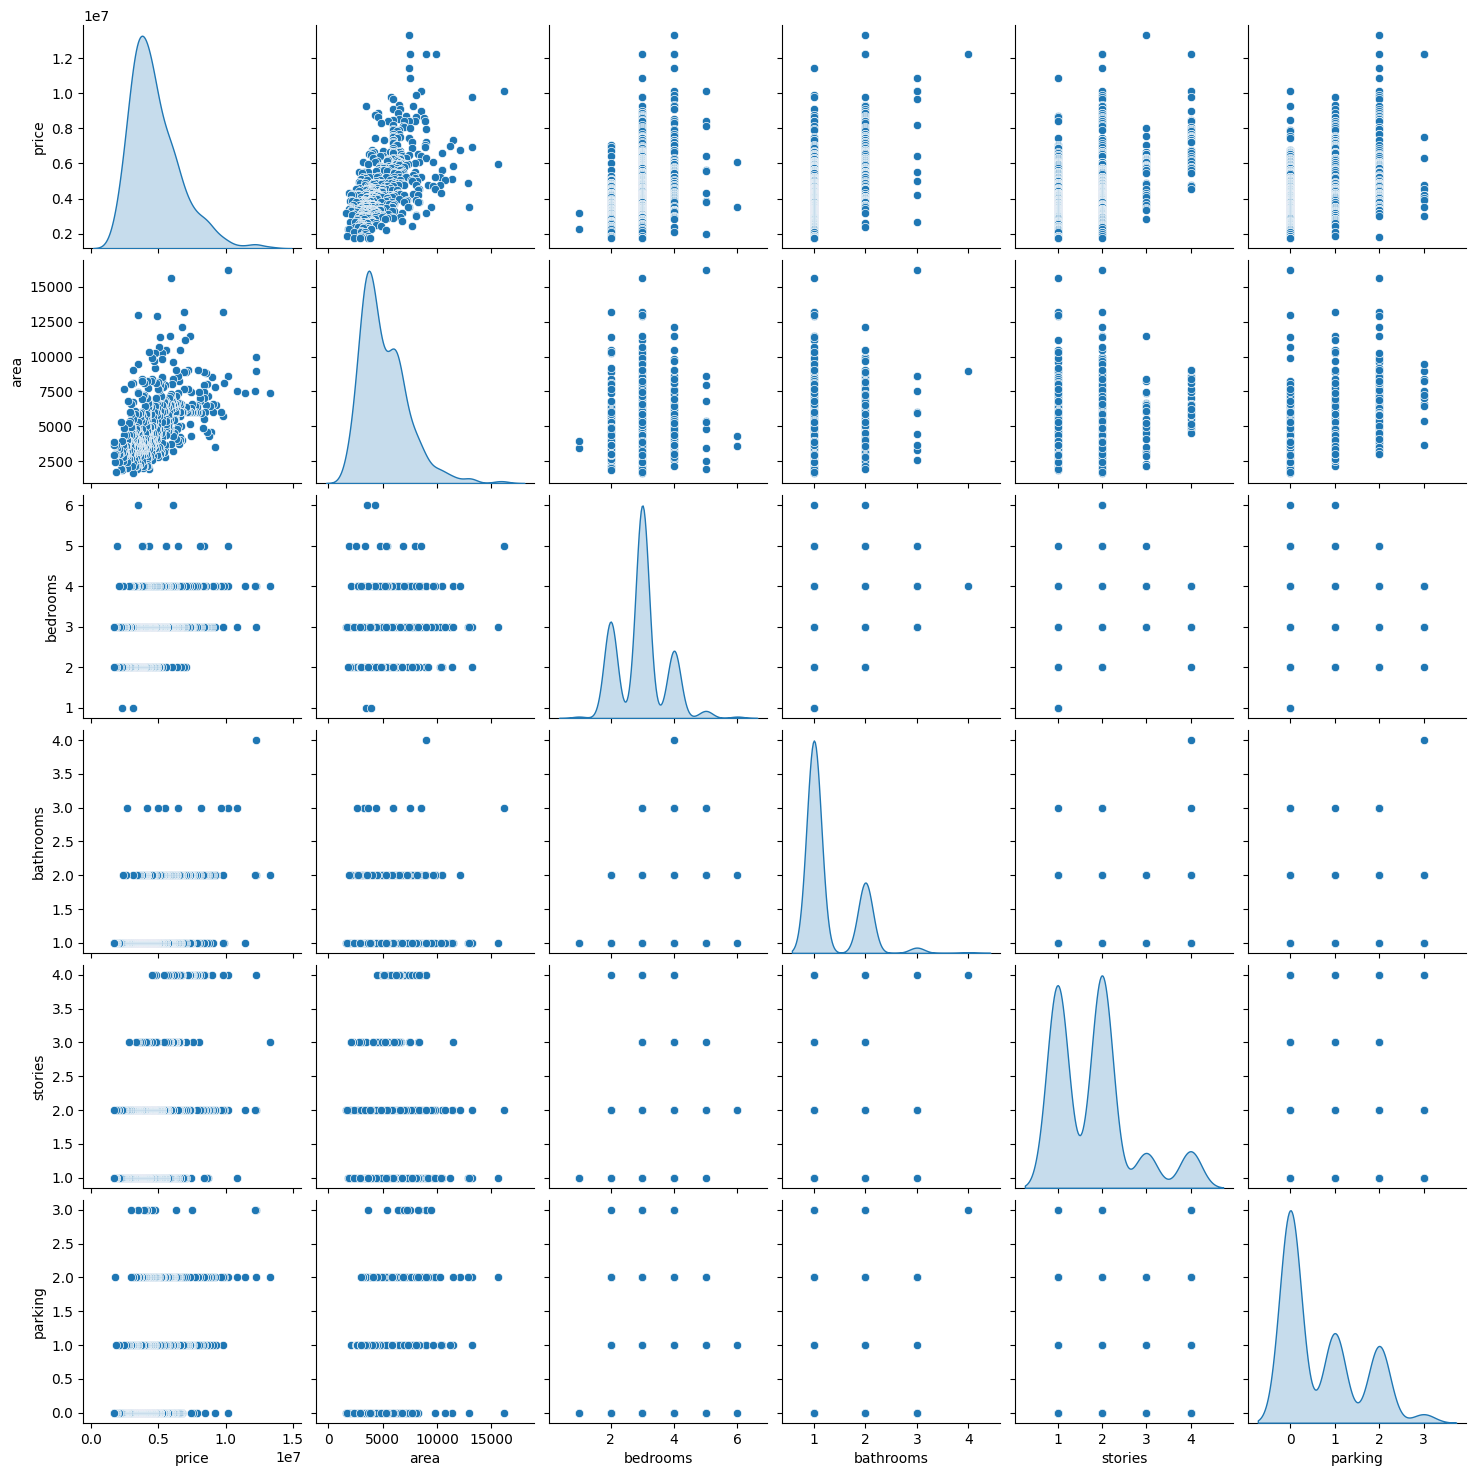

In [6]:
sns.pairplot(df[['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']], diag_kind="kde")
plt.show()


## Преобразование для категориальных признаков

In [7]:
dic = {'yes': 1, 'no': 0}
categorical_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
for col in categorical_columns:
    df[col] = df[col].map(dic)

## One-hot encoding для признака furnishingstatus

In [8]:
df = pd.get_dummies(df, columns=['furnishingstatus'], drop_first=True)

## Визуализация корреляционной матрицы


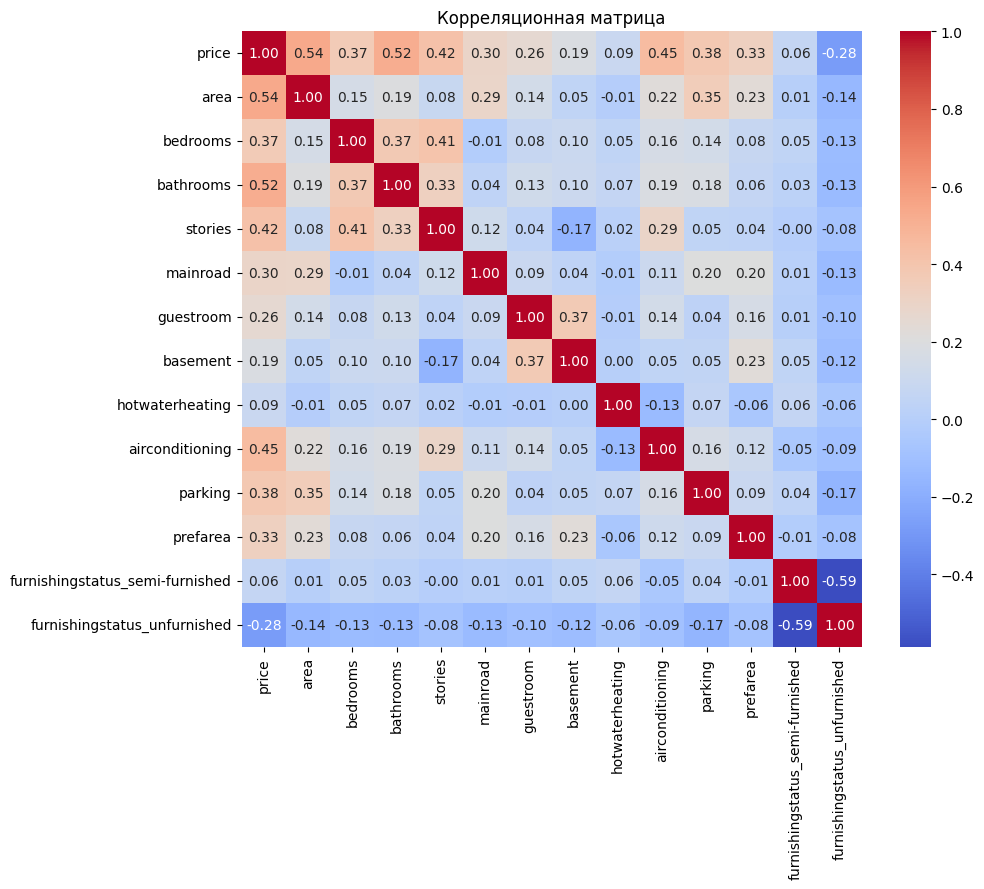

In [9]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляционная матрица")
plt.show()

## Масштабирование количественных признаков

In [10]:
numeric_columns = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
scaler = MinMaxScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

## Разделение датафрейма на предикторы и зависимую переменную

In [11]:
X = df.drop(columns=['price'])
y = df['price']

## Разделение данных на тренировочную и тестовую выборки

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Инициализация словаря, в котором будут результаты обучения

In [13]:
results = {}

## Функция для записи результатов обучения моделей

In [14]:
def res(model, y_test, y_pred):
  global results
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  results[model] = {
    "MAE": mae,
    "MSE": mse,
    "R2": r2
  }

## Обучение модели LinearRegression

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
res('LinearRegression', y_test, y_pred_lr)

## Обучение модели Lasso

In [16]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
res("Lasso Regression", y_test, y_pred_lasso)

## Обучение модели RandomForestRegressor

In [17]:
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15]}
gs_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
gs_rf.fit(X_train, y_train)
best_rf = gs_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
res("Random Forest", y_test, y_pred_rf)

## Обучение модели GradientBoostingRegressor

In [18]:
param_grid_gb = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': range(2, 8, 2)}
gs_gb = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_gb, cv=5, scoring='r2', n_jobs=-1)
gs_gb.fit(X_train, y_train)
best_gb = gs_gb.best_estimator_
y_pred_gb = best_gb.predict(X_test)
res("Gradient Boosting", y_test, y_pred_gb)

## Запись результатов в датафрейм + вывод

In [59]:
results_df = pd.DataFrame(results).T
print(results_df.sort_values(by="MAE", ascending=False))

                            MAE           MSE        R2
Gradient Boosting  1.033086e+06  1.938392e+12  0.616507
Random Forest      1.030249e+06  1.944191e+12  0.615360
Lasso Regression   9.700434e+05  1.754319e+12  0.652924
LinearRegression   9.700434e+05  1.754319e+12  0.652924


## Визуализация результатов модели Gradient Boosting

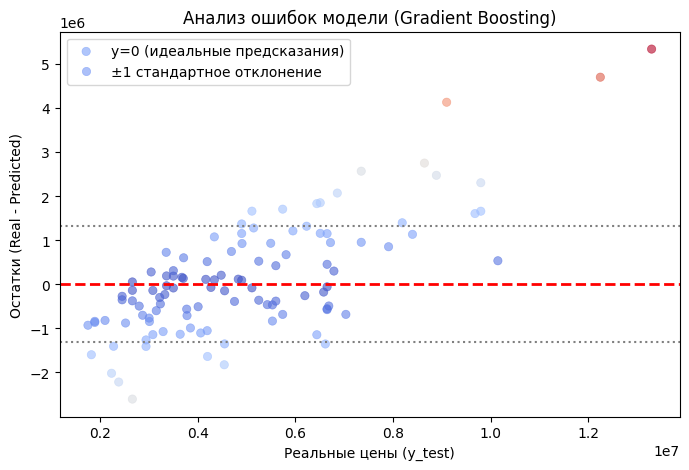

In [57]:
residuals_gb = y_test - y_pred_gb

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=residuals_gb, alpha=0.6, edgecolor=None, hue=np.abs(residuals_gb), palette="coolwarm")
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)

std_residuals = np.std(residuals_gb)
plt.axhline(y=std_residuals, color='gray', linestyle='dotted', label="±1 std")
plt.axhline(y=-std_residuals, color='gray', linestyle='dotted')

plt.xlabel("Реальные цены (y_test)")
plt.ylabel("Остатки (Real - Predicted)")
plt.title("Анализ ошибок модели (Gradient Boosting)")

plt.legend(["y=0 (идеальные предсказания)", "±1 стандартное отклонение"])

plt.show()

## Построение графика важности переменных

<ipython-input-42-66852c8b97ba>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gb_importance_df['Importance'], y=gb_importance_df['Feature'], palette='viridis')


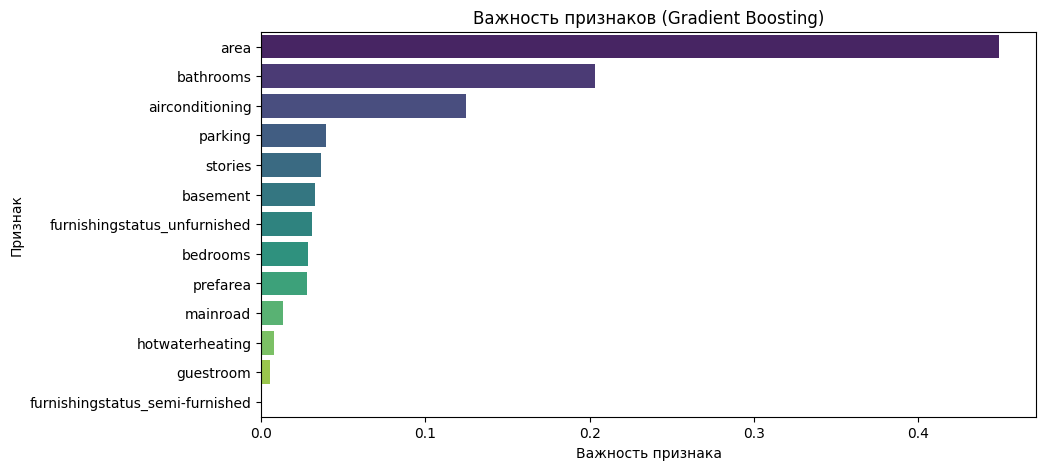

In [42]:
gb_importance = best_gb.feature_importances_
gb_features = X.columns
gb_importance_df = pd.DataFrame({'Feature': gb_features, 'Importance': gb_importance}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=gb_importance_df['Importance'], y=gb_importance_df['Feature'], palette='viridis')
plt.xlabel("Важность признака")
plt.ylabel("Признак")
plt.title("Важность признаков (Gradient Boosting)")
plt.show()

## Построение boxplot для реальных и предсказанных значений

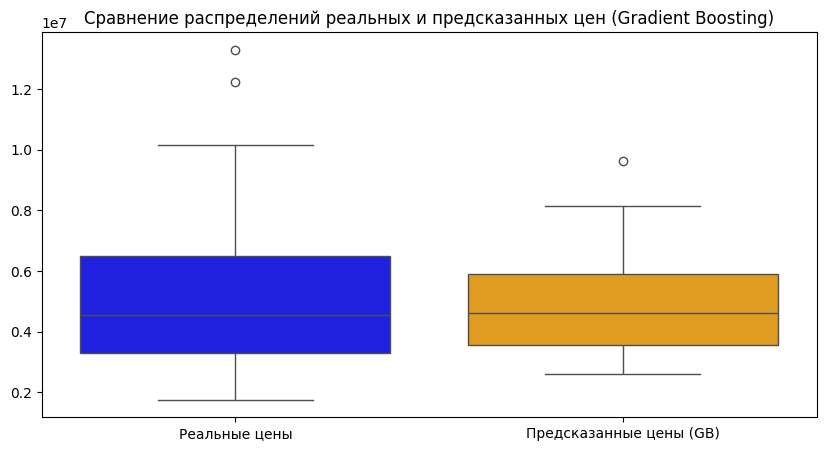

In [22]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=[y_test, y_pred_gb], palette=["blue", "orange"])
plt.xticks([0, 1], ["Реальные цены", "Предсказанные цены (GB)"])
plt.title("Сравнение распределений реальных и предсказанных цен (Gradient Boosting)")
plt.show()


## Визуализация результатов модели RandomForest

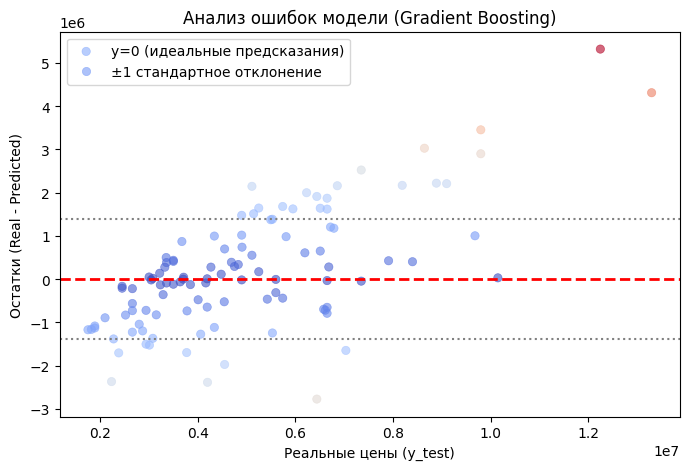

In [58]:
residuals_gb = y_test - y_pred_rf

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=residuals_rf, alpha=0.6, edgecolor=None, hue=np.abs(residuals_gb), palette="coolwarm")
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)

std_residuals = np.std(residuals_gb)
plt.axhline(y=std_residuals, color='gray', linestyle='dotted', label="±1 std")
plt.axhline(y=-std_residuals, color='gray', linestyle='dotted')

plt.xlabel("Реальные цены (y_test)")
plt.ylabel("Остатки (Real - Predicted)")
plt.title("Анализ ошибок модели (Gradient Boosting)")

plt.legend(["y=0 (идеальные предсказания)", "±1 стандартное отклонение"])

plt.show()

## Построение графика важности переменных

<ipython-input-43-97f82265aa10>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_importance_df['Importance'], y=rf_importance_df['Feature'], palette='viridis')


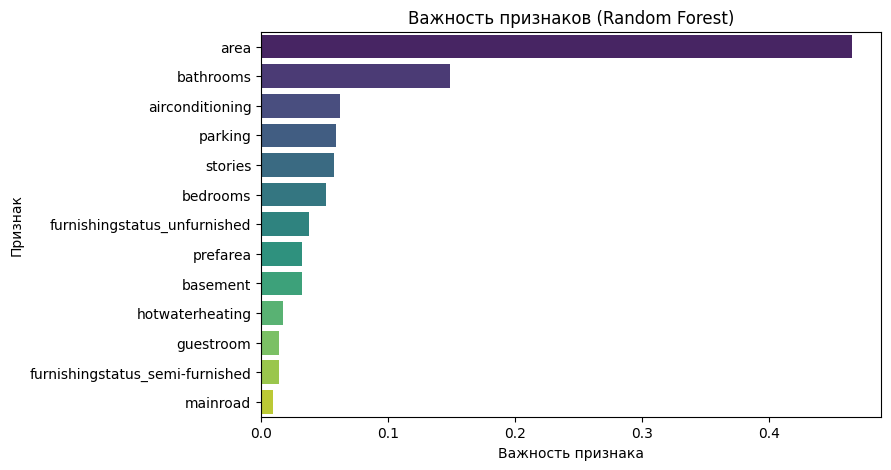

In [43]:
rf_importance = best_rf.feature_importances_
rf_feature = X.columns
rf_importance_df = pd.DataFrame({'Feature': rf_feature, 'Importance': rf_importance}).sort_values(by='Importance', ascending=False)

rf_importance_df

plt.figure(figsize=(8, 5))
sns.barplot(x=rf_importance_df['Importance'], y=rf_importance_df['Feature'], palette='viridis')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков (Random Forest)')
plt.show()

## Построение boxplot для реальных и предсказанных значений

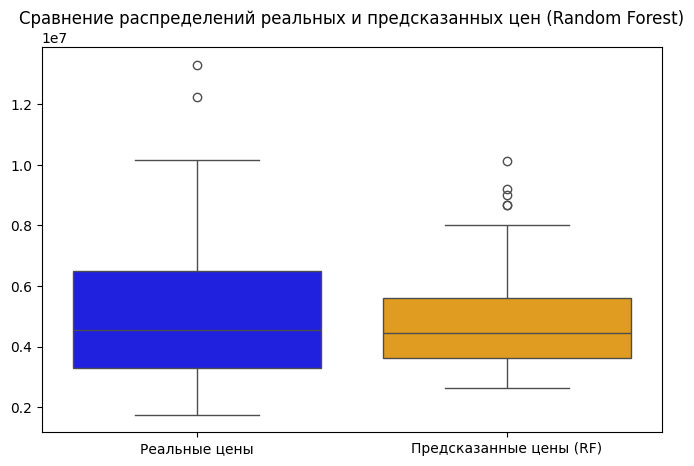

In [49]:
plt.figure(figsize=(8, 5))
sns.boxplot([y_test, y_pred_rf], palette=["blue", "orange"])
plt.xticks([0, 1], ["Реальные цены", "Предсказанные цены (RF)"])
plt.title("Сравнение распределений реальных и предсказанных цен (Random Forest)")
plt.show()